# Attack on Adult using a Decision Tree and a Statistical Generated Dataset (on the noisy dataset) without filtering of the points

In this notebook I use a statistical generated dataset to create the local decision tree. The statistical daaset is generated on the noisy dataset.

In [1]:
from pathlib import Path
import sys
from numba import njit

UTILS_RELATIVE_PATH = "../../../../"
sys.path.append(UTILS_RELATIVE_PATH)

MLEM_RELATIVE_PATH = "../../../../.."
sys.path.append(MLEM_RELATIVE_PATH)

LIME_RELATIVE_PATH = "../../../../../lime/"
sys.path.append(LIME_RELATIVE_PATH)

OUTPUT_FOLDER = Path("experiment_output")
OUTPUT_FOLDER.mkdir(exist_ok=True)

import logging
logging.disable('DEBUG')


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
import numpy as np
import scipy.spatial.distance as distance
import multiprocessing

np.random.seed(4321)
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer # type: ignore
from mlem.utilities import generate_balanced_dataset, save_pickle_bz2, load_pickle_bz2, save_txt

importing the experiment utilities and the mlem module

# Loading the Adult data

loading the Adult RandomForest and the dictionary with all the useful data

In [3]:
from utils.dataloading.adult import load_adult_data, load_adult_randomforest # type: ignore

BB = load_adult_randomforest()
BB_DATA = load_adult_data()

print(classification_report(BB_DATA['y_test'], BB.predict(BB_DATA['X_test'])))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8157
           1       0.79      0.61      0.69      2690

    accuracy                           0.86     10847
   macro avg       0.84      0.78      0.80     10847
weighted avg       0.86      0.86      0.86     10847



# Generating the statistical dataset

Using a `GaussianMixture` to generate a statistical dataset with the statistics of the black box's training set. The statistical dataset is filtered in order to keep the point closest to the instance.

In [6]:
print(*BB_DATA.keys())

X_train y_train X_test y_test X_validation y_validation X_validation_noisy y_validation_noisy X_attack_2_per_quantile y_attack_2_per_quantile X_attack_3_per_quantile y_attack_3_per_quantile categorical_features numerical_features categorical_features_mask centroids X_distance_separated y_distance_separated


In [4]:
from utils.filtering import filter_elements_std

In [7]:
from mlem.utilities import stat_sample_dataset, create_gaussian_mixture 
# set the noisy dataset
if not (OUTPUT_FOLDER / "gaussian_mixture.bz2").exists():
    gm = create_gaussian_mixture(BB_DATA['X_validation_noisy'])
    save_pickle_bz2(OUTPUT_FOLDER / "gaussian_mixture.bz2", gm)

gm = load_pickle_bz2(OUTPUT_FOLDER / "gaussian_mixture.bz2")
print(f"The number of components of the GaussianMixture is {gm.n_components}")

The number of components of the GaussianMixture is 11


In [8]:
def generate_data_statistical_std(x, num_samples):
    """Generate statistical data.

    Args:
        x (instance): ignored since we are not generating aroung it, just needed for the interface
        num_samples (int): number of samples to generate
    """
    return stat_sample_dataset(n_samples=num_samples, mixture_model=gm) # using the above GaussianMixture

In [9]:
test_representatives_x = BB_DATA['X_distance_separated']
test_representatives_y = BB_DATA['y_distance_separated']
n_datasets = len(test_representatives_x)

In [10]:
def generate_and_save(index, instance):
    # wrapper of the above functions to be able to generate the datasets in parallel
    output_path = OUTPUT_FOLDER / f"{index}"
    output_path.mkdir(exist_ok=True)
    # here we filter the elements
    balanced_dataset = generate_balanced_dataset(instance, 5000, BB, generate_data_statistical_std)
    balanced_dataset.to_csv(output_path / "statistical_generated.csv", index=False)
    
    with open(output_path / "instance.npy", "wb") as f:
        np.save(f, instance)


if not any([Path(OUTPUT_FOLDER / f"{j}" / "statistical_generated.csv").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(processes=8) as pool:
        pool.starmap(generate_and_save, [*enumerate(test_representatives_x)])
else:
    print("The statistical generated datasets already exist")

# Creating the Decision Trees

Creating the decision trees <span style="color:red"> if they don't already exist </span>.

In [11]:
from mlem.utilities import create_decision_tree

def train_decision_tree(datapath, model_name):
    statistical_generated = pd.read_csv(datapath / "statistical_generated.csv")
    X_train, X_test, y_train, y_test = train_test_split(statistical_generated.drop('Target', axis=1).to_numpy(), statistical_generated.Target.to_numpy(), test_size=0.33, random_state=42)
    model_path = datapath / model_name
    if not model_path.exists():
        dt = create_decision_tree(X_train, y_train, use_halving=True) 
        save_pickle_bz2(model_path, dt)
        save_txt(datapath / "dt_classification_report.txt", classification_report(y_test, dt.predict(X_test)))

In [13]:
models_name = "dt.bz2"
if not any([Path(OUTPUT_FOLDER / f"{j}" / "dt.bz2").exists() for j in range(len(test_representatives_x))]):
    with multiprocessing.Pool(8) as pool:
        pool.starmap(train_decision_tree, [(Path(OUTPUT_FOLDER / f"{i}"), models_name) for i in range(len(test_representatives_x))])
else:
    print("The DecisionTrees already exist")

The DecisionTrees already exist


# Attack on the Decision Trees to create the attack models

Attack on the decision trees using a <span style="background: green">statistical generated dataset</span> labeled by the decision trees to create the shadow models. The dataset elements aren't filtered using the std.

In [14]:
categorical_features_mask = BB_DATA['categorical_features_mask']

Creating the shadow models and the attack models.

In [15]:
from mlem.shadow_models import ShadowModelsManager
from mlem.utilities import create_adaboost
from mlem.attack_models import AttackModelsManager, AttackStrategy

In [16]:
def compute_statistics_local_model(dataset, true_y, local_model, black_box, output_folder, filename):
    local_y = local_model.predict(dataset.to_numpy())
    local_bb = black_box.predict(dataset.to_numpy())

    report_local = classification_report(true_y.to_numpy(), local_y)
    report_bb    = classification_report(true_y.to_numpy(), local_bb)

    fidelity = str(pd.DataFrame(local_y == local_bb).value_counts(normalize=True))

    with open(output_folder / filename, "w") as f:
        f.write("Statistics on the noisy validation dataset\n")
        
        f.write("local model\n")
        f.write(report_local)

        f.write("\nblack box\n")
        f.write(report_bb)

        f.write("\nFidelity between the local model and the black box\n")
        f.write(fidelity)

In [17]:
noisy_dataset_x = pd.DataFrame(BB_DATA['X_validation_noisy'])
noisy_dataset_y = pd.DataFrame(BB_DATA['y_validation_noisy'])
categorical_features_mask = BB_DATA['categorical_features_mask']

Run the attack only if it hasn't already been run

In [18]:
if not any([(OUTPUT_FOLDER / f"{i}" / "attack").exists() for i in range(len(test_representatives_x))]):
    
    for ind, path in enumerate([OUTPUT_FOLDER / f"{i}" for i in range(len(test_representatives_x))]):
        # load the local tree and label the noisy dataset
        local_tree = load_pickle_bz2(path / "dt.bz2")

        # compute fidelity and performances on the noisy dataset.
        compute_statistics_local_model(noisy_dataset_x, noisy_dataset_y, local_tree, BB, path, "statistics_statisticalgenerated.txt")

        # use the "local" decision tree to label the statistical dataset
        x_attack = noisy_dataset_x.to_numpy()    
        y_attack = local_tree.predict(x_attack)

        path_shadow = str(path / "shadow")

        shadow_models = ShadowModelsManager(
            n_models=4,
            results_path=path_shadow,
            test_size=0.5,
            random_state=123,
            model_creator_fn=create_adaboost,
            categorical_mask=categorical_features_mask
        )
        
        shadow_models.fit(x_attack, y_attack)

        # extracting the dataset for the attack models
        attack_models_dataset = shadow_models.get_attack_dataset()

        # saving the attack dataset
        attack_models_dataset.to_csv(path / "attack_models_train_dataset.csv", index=False)

        # Creating the attack model for each label using Adaboost
        path_attack = str(path / "attack")
        attack_models = AttackModelsManager(
                results_path=path_attack, model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
        )
        
        attack_models.fit(attack_models_dataset)
else:
    print("The attack models already exist")

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specifi

By looking at the test reports of the attack models, it seems that they <span style="background: red">perform bad on both classes</span> with an accuracy of $\simeq .50$

# Creating the ensembles

In [19]:
from mlem.ensemble import HardVotingClassifier, SoftVotingClassifier, KMostSureVotingClassifier
from utils.attack_evaluation import evaluate_attack

In [20]:
attack_models_0 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "0" / "model.pkl.bz2") for i in range(len(test_representatives_x))]
attack_models_1 = [load_pickle_bz2(OUTPUT_FOLDER / f"{i}" / "attack" / "1" / "model.pkl.bz2") for i in range(len(test_representatives_x))]

## Hard Voting

In [21]:
hv0 = HardVotingClassifier(classifiers=attack_models_0)
hv1 = HardVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.24      0.35     24656
         out       0.30      0.77      0.43     10570

    accuracy                           0.40     35226
   macro avg       0.50      0.50      0.39     35226
weighted avg       0.58      0.40      0.38     35226


Class 0
              precision    recall  f1-score   support

          in       0.70      0.05      0.10     19801
         out       0.30      0.95      0.46      8532

    accuracy                           0.32     28333
   macro avg       0.50      0.50      0.28     28333
weighted avg       0.58      0.32      0.21     28333


Class 1
              precision    recall  f1-score   support

          in       0.70      0.98      0.82      4855
         out       0.32      0.02      0.04      2038

    accuracy                           0.70      6893
   macro avg       0.51      0.50      0.43      6893
weighted avg       0.59      0.70      0.59 

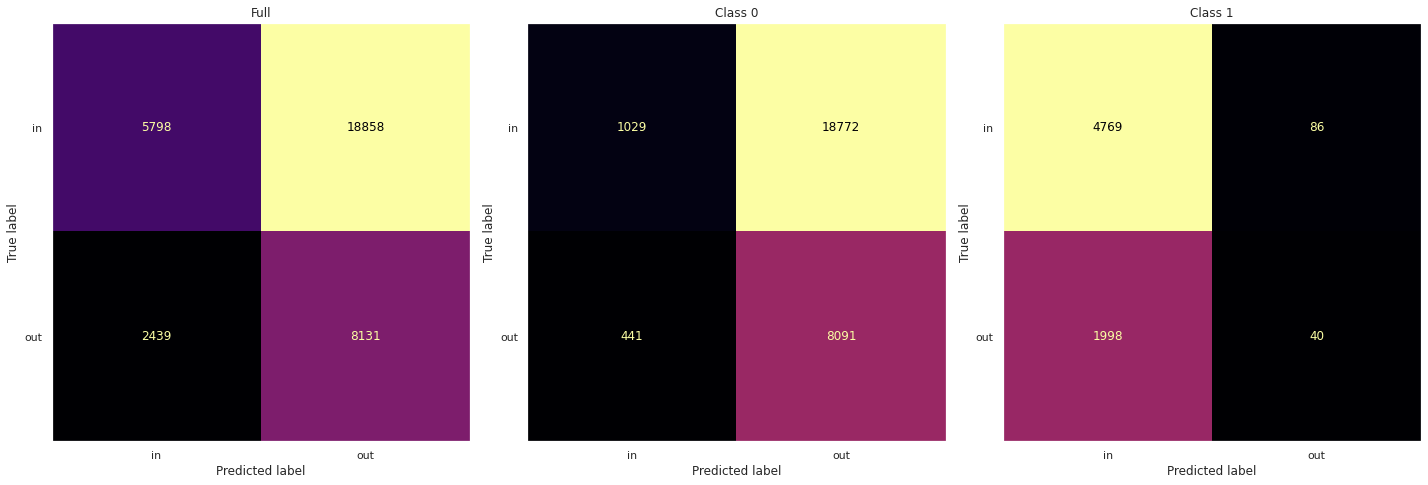

In [22]:
evaluate_attack(hv0, hv1, BB, BB_DATA)

## Soft Voting

In [23]:
sv0 = SoftVotingClassifier(classifiers=attack_models_0)
sv1 = SoftVotingClassifier(classifiers=attack_models_1)

report full
              precision    recall  f1-score   support

          in       0.70      0.24      0.36     25308
         out       0.30      0.76      0.43     10847

    accuracy                           0.40     36155
   macro avg       0.50      0.50      0.39     36155
weighted avg       0.58      0.40      0.38     36155


Class 0
              precision    recall  f1-score   support

          in       0.70      0.06      0.11     20353
         out       0.30      0.94      0.46      8766

    accuracy                           0.33     29119
   macro avg       0.50      0.50      0.28     29119
weighted avg       0.58      0.33      0.22     29119


Class 1
              precision    recall  f1-score   support

          in       0.70      0.96      0.81      4955
         out       0.30      0.04      0.07      2081

    accuracy                           0.69      7036
   macro avg       0.50      0.50      0.44      7036
weighted avg       0.58      0.69      0.59 

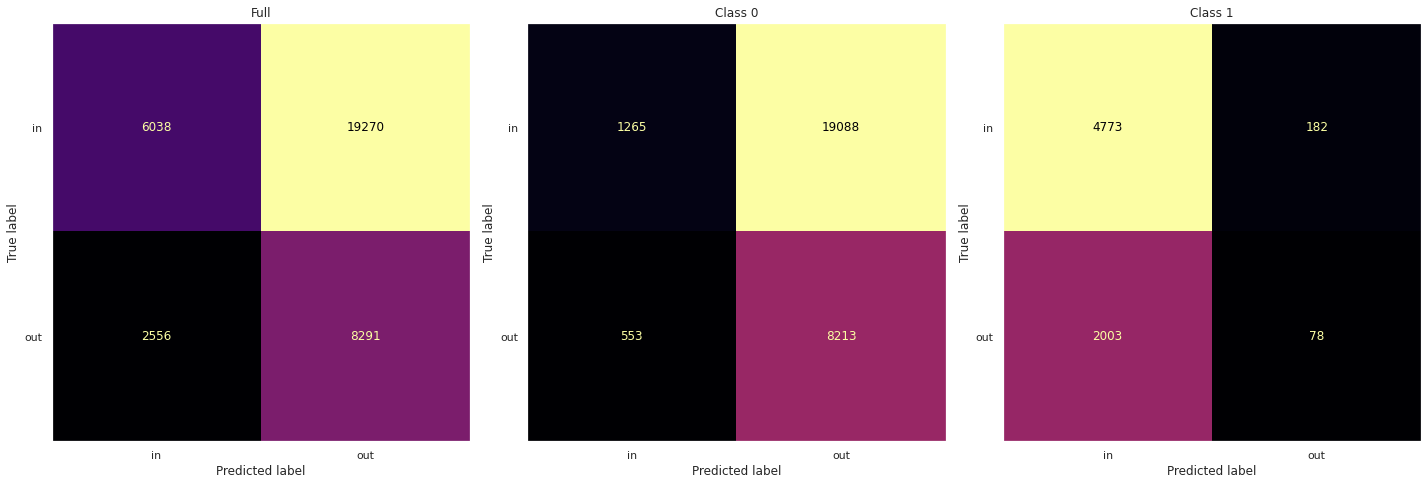

In [24]:
evaluate_attack(sv0, sv1, BB, BB_DATA)